This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to Keras and TensorFlow

## What's TensorFlow?

## What's Keras?

## Keras and TensorFlow: A brief history

## Setting up a deep-learning workspace

### Jupyter notebooks: The preferred way to run deep-learning experiments

### Using Colaboratory

#### First steps with Colaboratory

#### Installing packages with pip

#### Using the GPU runtime

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [2]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [3]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [4]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[1.4956772]
 [0.5613857]
 [1.0777059]], shape=(3, 1), dtype=float32)


In [5]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.75008166]
 [0.561996  ]
 [0.61485386]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [6]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

To train a model, we’ll need to update its state, which is a set of tensors. If tensors
aren’t assignable, how do we do it? That’s where variables come in. tf.Variable is the
class meant to manage modifiable state in TensorFlow.

**Creating a TensorFlow variable**

In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.57383657],
       [-2.9154003 ],
       [-0.13761391]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [8]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [10]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [11]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

> This is most commonly used to retrieve the gradients of the loss of a model with
respect to its weights: gradients = tape.gradient(loss, weights). You saw this in
action in chapter 2.

**Using `GradientTape` with constant tensor inputs**

In [ ]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

Trainable variables are watched by default because computing the gradient of a loss with regard to a list of
trainable variables is the most common use of the gradient tape.

The gradient tape is a powerful utility, even capable of computing second-order gradients, that is to say, the gradient of a gradient. For instance, the gradient of the position of an object with regard to time is the speed of that object, and the second-order gradient is its acceleration.

If you measure the position of a falling apple along a vertical axis over time and find that it verifies position(time) = 4.9 * time ** 2, what is its acceleration? Let’s use two nested gradient tapes to find out.

**Using nested gradient tapes to compute second-order gradients**

In [15]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [16]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [17]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

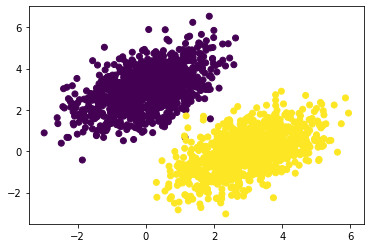

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [20]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [21]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [22]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [23]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

For simplicity, we’ll do batch training instead of mini-batch training: we’ll run each training
step (gradient computation and weight update) for all the data, rather than iterate over
the data in small batches. On one hand, this means that each training step will take
much longer to run, since we’ll compute the forward pass and the gradients for 2,000
samples at once. On the other hand, each gradient update will be much more effective
at reducing the loss on the training data, since it will encompass information from all
training samples instead of, say, only 128 random samples. As a result, we will need many
fewer steps of training, and we should use a larger learning rate than we would typically
use for mini-batch training (we’ll use learning_rate = 0.1)

**The batch training loop**

In [25]:
for step in range(100):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.0279
Loss at step 1: 0.0275
Loss at step 2: 0.0272
Loss at step 3: 0.0269
Loss at step 4: 0.0266
Loss at step 5: 0.0263
Loss at step 6: 0.0261
Loss at step 7: 0.0259
Loss at step 8: 0.0257
Loss at step 9: 0.0255
Loss at step 10: 0.0253
Loss at step 11: 0.0252
Loss at step 12: 0.0250
Loss at step 13: 0.0249
Loss at step 14: 0.0248
Loss at step 15: 0.0247
Loss at step 16: 0.0246
Loss at step 17: 0.0245
Loss at step 18: 0.0244
Loss at step 19: 0.0244
Loss at step 20: 0.0243
Loss at step 21: 0.0242
Loss at step 22: 0.0242
Loss at step 23: 0.0241
Loss at step 24: 0.0241
Loss at step 25: 0.0240
Loss at step 26: 0.0240
Loss at step 27: 0.0240
Loss at step 28: 0.0239
Loss at step 29: 0.0239
Loss at step 30: 0.0239
Loss at step 31: 0.0238
Loss at step 32: 0.0238
Loss at step 33: 0.0238
Loss at step 34: 0.0238
Loss at step 35: 0.0238
Loss at step 36: 0.0237
Loss at step 37: 0.0237
Loss at step 38: 0.0237
Loss at step 39: 0.0237
Loss at step 40: 0.0237
Loss at step 41: 0.0237
Lo

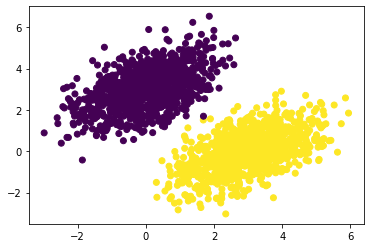

In [26]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

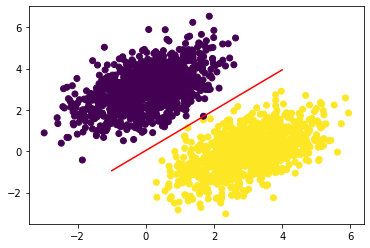

In [27]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [28]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [29]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [32]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [33]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [34]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [35]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [36]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [37]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 2ms/step - loss: 10.5048 - binary_accuracy: 0.9165
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 10.1395 - binary_accuracy: 0.9155
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 9.8290 - binary_accuracy: 0.9140
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 9.5322 - binary_accuracy: 0.9110
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 9.2411 - binary_accuracy: 0.9105


In [38]:
# How to return metrics after the fact.
history.history

{'loss': [10.504769325256348,
  10.139501571655273,
  9.828954696655273,
  9.532211303710938,
  9.24111270904541],
 'binary_accuracy': [0.9164999723434448,
  0.9154999852180481,
  0.9139999747276306,
  0.9110000133514404,
  0.9104999899864197]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

reserve a subset of the training data as validation data: you won’t be training the model
on this data, but you will use it to compute a loss value and metrics value.

In [39]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 4ms/step - loss: 0.5378 - binary_accuracy: 0.8714 - val_loss: 0.0478 - val_binary_accuracy: 0.9900
Epoch 2/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0662 - binary_accuracy: 0.9579 - val_loss: 0.0926 - val_binary_accuracy: 0.9317
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0698 - binary_accuracy: 0.9600 - val_loss: 0.1581 - val_binary_accuracy: 0.7717
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0702 - binary_accuracy: 0.9600 - val_loss: 0.0544 - val_binary_accuracy: 0.9983
Epoch 5/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0655 - binary_accuracy: 0.9657 - val_loss: 0.1732 - val_binary_accuracy: 0.9383


Note that if you want to compute the validation loss and metrics after the training
is complete, you can call the evaluate() method:

In [41]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 [==============================] - 0s 2ms/step - loss: 0.1732 - binary_accuracy: 0.9383


### Inference: Using a model after training

For instance, if we use predict() on some of our validation data with the linear
model we trained earlier, we get scalar scores that correspond to the model’s prediction
for each input sample:

In [40]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[ 0.20777434]
 [ 0.60380733]
 [-0.10298628]
 [-0.02113599]
 [ 0.35081422]
 [ 1.4078429 ]
 [ 1.245348  ]
 [ 1.2931107 ]
 [ 0.65357965]
 [ 1.2190387 ]]


## Summary